# Generate Custom ROC and PRC Plots (for STREAMLINE)
Generates custom ROC and PRC plots to provide a way to generate modified versions of these plots without rerunning or directly editing the code in the original pipeline. 

Designed to operate following application of pipeline phases 1-6. Relies on folder/file hierarchy saved by the pipeline.
 

## Import Packages

In [1]:
import os
import pandas as pd
import pickle
from statistics import mean,stdev
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from scipy import interp,stats

import warnings
warnings.filterwarnings('ignore')

# Jupyter Notebook Hack: This code ensures that the results of multiple commands within a given cell are all displayed, rather than just the last. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Set Run Parameters

In [2]:
experiment_path = "../demo/demo"
targetDataName = None # 'None' if user wants to generate visualizations for all analyzed datasets
algorithms = [] #use empty list if user wishes to plot feature importance for all modeling algorithms that were run in pipeline.
name_modifier = '_New' # Modifies standard plot filenames to avoid overwriting originals.
legend_inside_plot = True #place legend ouside plot in upper right hand corner, other wise placed inside on upper right hand corner.
plot_ROC = True # For each algorithm plot ROC curve - including lines for each trained CV model.
plot_PRC = True # For each algorithm plot PRC curve - including lines for each trained CV model.
plot_meta_ROC = True #Generate ROC summarizing average ROC curves (all cvs) for each algorithm
plot_meta_PRC = True #Generate PRC summarizing average ROC curves (all cvs) for each algorithm

## Automatically detect data folder names

In [3]:
# Get dataset paths for all completed dataset analyses in experiment folder
datasets = os.listdir(experiment_path)

# Name of experiment folder
experiment_name = experiment_path.split('/')[-1] 

datasets = os.listdir(experiment_path)
remove_list = ['.DS_Store', 'metadata.pickle', 'metadata.csv', 'algInfo.pickle',
                'DatasetComparisons', 'jobs', 'jobsCompleted', 'logs',
                'KeyFileCopy', 'dask_logs',
                experiment_name + '_ML_Pipeline_Report.pdf']
for text in remove_list:
    if text in datasets:
        datasets.remove(text)

datasets = sorted(datasets) # ensures consistent ordering of datasets
print("Analyzed Datasets: " + str(datasets))

Analyzed Datasets: ['hcc-data_example', 'hcc-data_example_custom']


## Load other necessary parameters

In [4]:
# Unpickle metadata from previous phase
file = open(experiment_path+'/'+"metadata.pickle", 'rb')
metadata = pickle.load(file)
file.close()
# Load variables specified earlier in the pipeline from metadata
class_label = metadata['Class Label']
instance_label = metadata['Instance Label']
cv_partitions = int(metadata['CV Partitions'])

# Unpickle algorithm information from previous phase
file = open(experiment_path+'/'+"algInfo.pickle", 'rb')
algInfo = pickle.load(file)
file.close()
algorithms = []
abbrev = {}
colors = {}
for key in algInfo:
    if algInfo[key][0]: # If that algorithm was used
        algorithms.append(key)
        abbrev[key] = (algInfo[key][1])
        colors[key] = (algInfo[key][2])
        
print(algorithms)    

['Decision Tree', 'Logistic Regression', 'Naive Bayes']


## Define necessary methods

In [5]:
def primaryStats(algorithms,original_headers,cv_partitions,full_path,data_name,instance_label,class_label,abbrev,colors,plot_ROC,plot_PRC,name_modifier,legend_inside_plot):
    """ Combine classification metrics and model feature importance scores"""
    result_table = []
    metric_dict = {}
    for algorithm in algorithms: #completed for each individual ML modeling algorithm
        alg_result_table = [] #stores values used in ROC and PRC plots
        # Define evaluation stats variable lists
        s_bac = [] # balanced accuracies
        s_ac = [] # standard accuracies
        s_f1 = [] # F1 scores
        s_re = [] # recall values
        s_sp = [] # specificities
        s_pr = [] # precision values
        s_tp = [] # true positives
        s_tn = [] # true negatives
        s_fp = [] # false positives
        s_fn = [] # false negatives
        s_npv = [] # negative predictive values
        s_lrp = [] # likelihood ratio positive values
        s_lrm = [] # likelihood ratio negative values
        # Define ROC plot variable lists
        tprs = [] # true postitive rates
        aucs = [] #areas under ROC curve
        mean_fpr = np.linspace(0, 1, 100) #used to plot all CVs in single ROC plot
        mean_recall = np.linspace(0, 1, 100) #used to plot all CVs in single PRC plot
        # Define PRC plot variable lists
        precs = [] #precision values for PRC
        praucs = [] #area under PRC curve
        aveprecs = [] #average precisions for PRC
        
        #Gather statistics over all CV partitions
        for cvCount in range(0,cv_partitions):
            #Unpickle saved metrics from previous phase
            result_file = full_path+'/model_evaluation/pickled_metrics/'+abbrev[algorithm]+"_CV_"+str(cvCount)+"_metrics.pickle"
            file = open(result_file, 'rb')
            results = pickle.load(file)
            file.close()
            #Separate pickled results
            metricList = results[0]
            fpr = results[1]
            tpr = results[2]
            roc_auc = results[3]
            prec = results[4]
            recall = results[5]
            prec_rec_auc = results[6]
            ave_prec = results[7]
            #Separate metrics from metricList
            s_bac.append(metricList[0])
            s_ac.append(metricList[1])
            s_f1.append(metricList[2])
            s_re.append(metricList[3])
            s_sp.append(metricList[4])
            s_pr.append(metricList[5])
            s_tp.append(metricList[6])
            s_tn.append(metricList[7])
            s_fp.append(metricList[8])
            s_fn.append(metricList[9])
            s_npv.append(metricList[10])
            s_lrp.append(metricList[11])
            s_lrm.append(metricList[12])
            #update list that stores values used in ROC and PRC plots
            alg_result_table.append([fpr, tpr, roc_auc, prec, recall, prec_rec_auc, ave_prec])
            # Update ROC plot variable lists needed to plot all CVs in one ROC plot
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            aucs.append(roc_auc)
            # Update PRC plot variable lists needed to plot all CVs in one PRC plot
            precs.append(interp(mean_recall, recall, prec))
            praucs.append(prec_rec_auc)
            aveprecs.append(ave_prec)
            
        print(algorithm)
        #Define values for the mean ROC line (mean of individual CVs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs)
        #Generate ROC Plot (including individual CV's lines, average line, and no skill line) - based on https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html-----------------------
        if plot_ROC:
            # Set figure dimensions
            plt.rcParams["figure.figsize"] = (6,6)
            # Plot individual CV ROC lines
            for i in range(cv_partitions):
                plt.plot(alg_result_table[i][0], alg_result_table[i][1], lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.3f)' % (i, alg_result_table[i][2]))
            # Plot no-skill line
            plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='No-Skill', alpha=.8)
            # Plot average line for all CVs
            std_auc = np.std(aucs) # AUC standard deviations across CVs
            plt.plot(mean_fpr, mean_tpr, color=colors[algorithm],label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),lw=2, alpha=.8)
            # Plot standard deviation grey zone of curves
            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
            plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
            #Specify plot axes,labels, and legend
            plt.xlim([-0.05, 1.05])
            plt.ylim([-0.05, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            if legend_inside_plot:
                plt.legend(loc="lower right")
            else:
                plt.legend(loc="upper left", bbox_to_anchor=(1.01,1))
            #Export and/or show plot
            plt.savefig(full_path+'/model_evaluation/'+abbrev[algorithm]+"_ROC"+name_modifier+".png", bbox_inches="tight")
            plt.show()

        #Define values for the mean PRC line (mean of individual CVs)
        mean_prec = np.mean(precs, axis=0)
        mean_pr_auc = np.mean(praucs)
        #Generate PRC Plot (including individual CV's lines, average line, and no skill line)------------------------------------------------------------------------------------------------------------------
        if plot_PRC:
            # Set figure dimensions
            plt.rcParams["figure.figsize"] = (6,6)
            # Plot individual CV PRC lines
            for i in range(cv_partitions):
                plt.plot(alg_result_table[i][4], alg_result_table[i][3], lw=1, alpha=0.3, label='PRC fold %d (AUC = %0.3f)' % (i, alg_result_table[i][5]))
            #Estimate no skill line based on the fraction of cases found in the first test dataset
            test = pd.read_csv(full_path + '/CVDatasets/' + data_name + '_CV_0_Test.csv') #Technically there could be a unique no-skill line for each CV dataset based on final class balance (however only one is needed, and stratified CV attempts to keep partitions with similar/same class balance)
            testY = test[class_label].values
            noskill = len(testY[testY == 1]) / len(testY)  # Fraction of cases
            # Plot no-skill line
            plt.plot([0, 1], [noskill, noskill], color='orange', linestyle='--', label='No-Skill', alpha=.8)
            # Plot average line for all CVs
            std_pr_auc = np.std(praucs)
            # Plot standard deviation grey zone of curves
            plt.plot(mean_recall, mean_prec, color=colors[algorithm],label=r'Mean PRC (AUC = %0.3f $\pm$ %0.3f)' % (mean_pr_auc, std_pr_auc),lw=2, alpha=.8)
            std_prec = np.std(precs, axis=0)
            precs_upper = np.minimum(mean_prec + std_prec, 1)
            precs_lower = np.maximum(mean_prec - std_prec, 0)
            plt.fill_between(mean_recall, precs_lower, precs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
            #Specify plot axes,labels, and legend
            plt.xlim([-0.05, 1.05])
            plt.ylim([-0.05, 1.05])
            plt.xlabel('Recall (Sensitivity)')
            plt.ylabel('Precision (PPV)')
            if legend_inside_plot:
                plt.legend(loc="upper right")
            else:
                plt.legend(loc="upper left", bbox_to_anchor=(1.01,1))
            #Export and/or show plot
            plt.savefig(full_path+'/model_evaluation/'+abbrev[algorithm]+"_PRC"+name_modifier+".png", bbox_inches="tight")
            plt.show()
                
        #Export and save all CV metric stats for each individual algorithm  -----------------------------------------------------------------------------
        results = {'Balanced Accuracy': s_bac, 'Accuracy': s_ac, 'F1 Score': s_f1, 'Sensitivity (Recall)': s_re, 'Specificity': s_sp,'Precision (PPV)': s_pr, 'TP': s_tp, 'TN': s_tn, 'FP': s_fp, 'FN': s_fn, 'NPV': s_npv, 'LR+': s_lrp, 'LR-': s_lrm, 'ROC AUC': aucs,'PRC AUC': praucs, 'PRC APS': aveprecs}
        metric_dict[algorithm] = results

        #Store ave metrics for creating global ROC and PRC plots later
        mean_ave_prec = np.mean(aveprecs)
        result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'recall':mean_recall, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
        result_table.append(result_dict)
    #Result table later used to create global ROC an PRC plots comparing average ML algorithm performance.
    result_table = pd.DataFrame.from_dict(result_table)
    result_table.set_index('algorithm',inplace=True)

    return result_table,metric_dict


In [6]:
def doPlotROC(result_table,colors,full_path,name_modifier,legend_inside_plot):
    """ Generate ROC plot comparing average ML algorithm performance (over all CV training/testing sets)"""
    count = 0
    #Plot curves for each individual ML algorithm
    for i in result_table.index:
        plt.plot(result_table.loc[i]['fpr'],result_table.loc[i]['tpr'], color=colors[i],label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
        count += 1
    # Set figure dimensions
    plt.rcParams["figure.figsize"] = (6,6)
    # Plot no-skill line
    plt.plot([0, 1], [0, 1], color='orange', linestyle='--', label='No-Skill', alpha=.8)
    #Specify plot axes,labels, and legend
    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=15)
    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)
    if legend_inside_plot:
        plt.legend(loc="lower right")
    else:
        plt.legend(loc="upper left", bbox_to_anchor=(1.01,1))
    #Export and/or show plot
    plt.savefig(full_path+'/model_evaluation/Summary_ROC'+name_modifier+'.png', bbox_inches="tight")
    plt.show()

In [7]:
def doPlotPRC(result_table,colors,full_path,data_name,instance_label,class_label,name_modifier,legend_inside_plot):
    """ Generate PRC plot comparing average ML algorithm performance (over all CV training/testing sets)"""
    count = 0
    #Plot curves for each individual ML algorithm
    for i in result_table.index:
        plt.plot(result_table.loc[i]['recall'],result_table.loc[i]['prec'], color=colors[i],label="{}, AUC={:.3f}, APS={:.3f}".format(i, result_table.loc[i]['pr_auc'],result_table.loc[i]['ave_prec']))
        count += 1
    #Estimate no skill line based on the fraction of cases found in the first test dataset
    test = pd.read_csv(full_path+'/CVDatasets/'+data_name+'_CV_0_Test.csv')
    if instance_label != 'None':
        test = test.drop(instance_label, axis=1)
    testY = test[class_label].values
    noskill = len(testY[testY == 1]) / len(testY)  # Fraction of cases
    # Plot no-skill line
    plt.plot([0, 1], [noskill, noskill], color='orange', linestyle='--',label='No-Skill', alpha=.8)
    #Specify plot axes,labels, and legend
    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("Recall (Sensitivity)", fontsize=15)
    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("Precision (PPV)", fontsize=15)
    if legend_inside_plot:
        plt.legend(loc="upper right")
    else:
        plt.legend(loc="upper left", bbox_to_anchor=(1.01,1))
    #Export and/or show plot
    plt.savefig(full_path+'/model_evaluation/Summary_PRC'+name_modifier+'.png', bbox_inches="tight")
    plt.show()

## Generate ROC and PRC plots

Vizualized Datasets: ['hcc-data_example_custom']
---------------------------------------
hcc-data_example_custom
---------------------------------------
Decision Tree


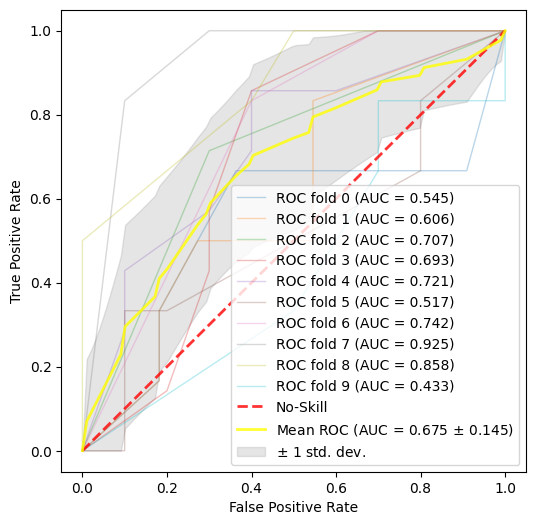

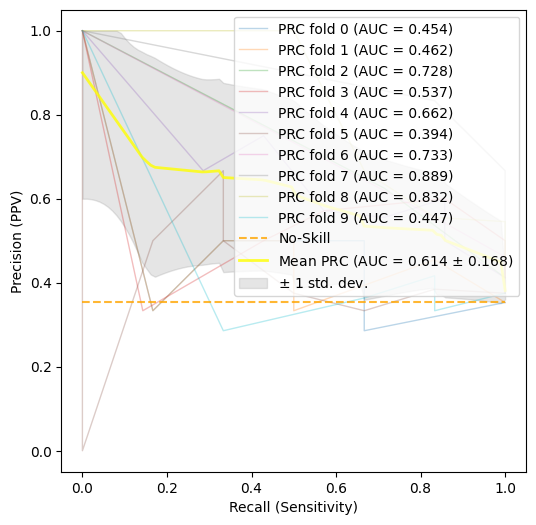

Logistic Regression


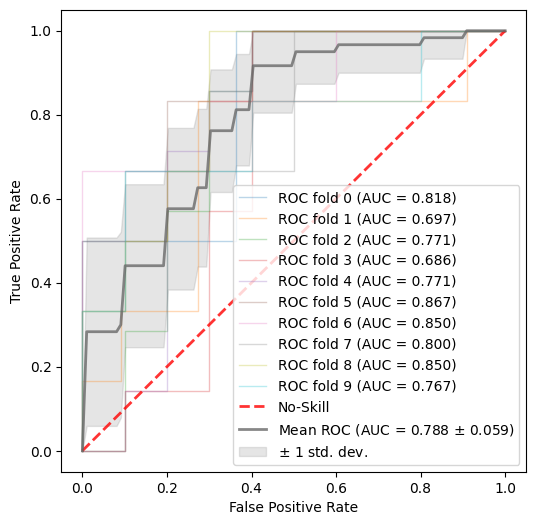

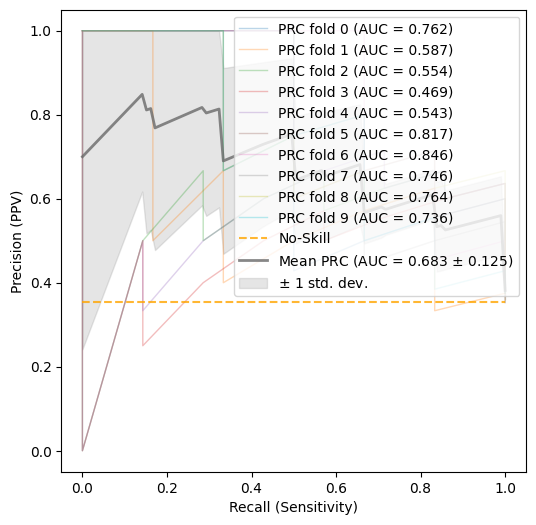

Naive Bayes


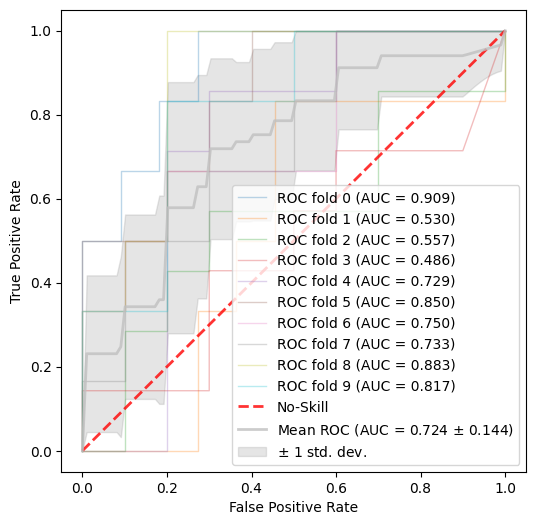

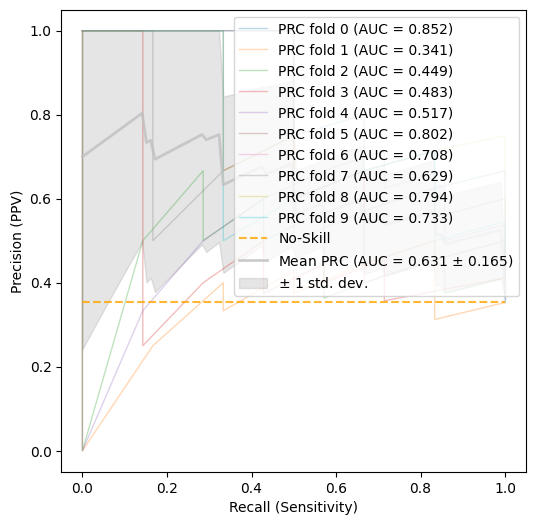

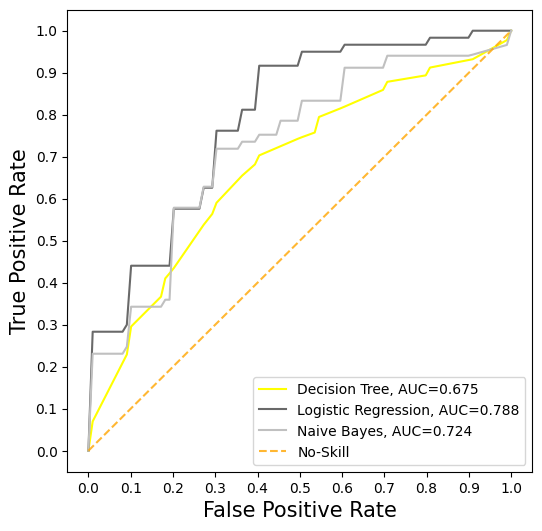

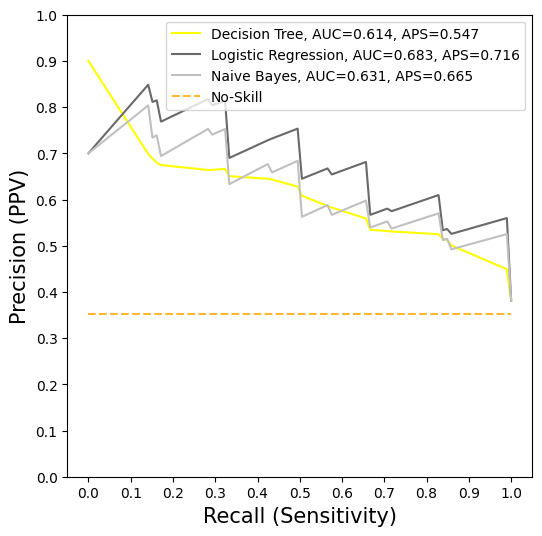

In [8]:
if not targetDataName == 'None': # User specified one analyzed dataset above (if more than one were analyzed)
    for each in datasets:
        if not each == targetDataName:
            datasets.remove(each)
    print("Vizualized Datasets: "+str(datasets))

for each in datasets: #each analyzed dataset to make plots for
    print("---------------------------------------")
    print(each)
    print("---------------------------------------")
    full_path = experiment_path+'/'+each
    #Create folder for tree vizualization files
    original_headers = pd.read_csv(full_path+"/exploratory/OriginalFeatureNames.csv",sep=',').columns.values.tolist() #Get Original Headers
    
    result_table,metric_dict = primaryStats(algorithms,original_headers,cv_partitions,full_path,each,instance_label,class_label,abbrev,colors,plot_ROC,plot_PRC,name_modifier,legend_inside_plot)

    #Plot ROC and PRC curves comparing average ML algorithm performance (averaged over all CVs)
    if plot_meta_ROC:
        doPlotROC(result_table,colors,full_path,name_modifier,legend_inside_plot)
    if plot_meta_PRC:
        doPlotPRC(result_table,colors,full_path,each,instance_label,class_label,name_modifier,legend_inside_plot)
